In [1]:
import os
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Dataset Path

In [3]:
import os

DATASET_PATH = "/kaggle/input/car-body-style-dataset"

print("Contents of dataset root:")
print(os.listdir(DATASET_PATH))


Contents of dataset root:
['CarBodyStyles']


In [4]:
DATASET_PATH = "/kaggle/input/car-body-style-dataset/CarBodyStyles"

classes = os.listdir(DATASET_PATH)
print("Car Types Found:", classes)

for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(DATASET_PATH, cls)))} images")


Car Types Found: ['Minivan', 'Sedan', 'Buggy', 'Hatchback', 'Coupe', 'Limousine', 'Convertible']
Minivan: 515 images
Sedan: 501 images
Buggy: 334 images
Hatchback: 527 images
Coupe: 466 images
Limousine: 344 images
Convertible: 657 images


Image Transforms

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


SAFE Image Loader

In [6]:
def safe_image_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except:
        return None


Custom Safe Dataset

In [7]:
class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = safe_image_loader(path)

        if image is None:
            new_index = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(new_index)

        if self.transform:
            image = self.transform(image)

        return image, target


Dataset Load + Split

In [8]:
full_dataset = SafeImageFolder(
    root=DATASET_PATH,
    transform=train_transform
)

num_classes = len(full_dataset.classes)
print("Number of classes:", num_classes)
print("Class names:", full_dataset.classes)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size]
)

val_dataset.dataset.transform = val_transform


Number of classes: 7
Class names: ['Buggy', 'Convertible', 'Coupe', 'Hatchback', 'Limousine', 'Minivan', 'Sedan']


DataLoaders

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


VGG16 Model + Custom Classifier

In [10]:
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False  

model.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

model = model.to(device)
print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 214MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Loss & Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-4
)


Training Loop

In [13]:
import os
import random
import numpy as np
from tqdm import tqdm 

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from PIL import Image

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total


    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Loss: {running_loss:.4f} "
          f"Train Acc: {train_acc:.2f}% "
          f"Val Acc: {val_acc:.2f}%")


Epoch 1/10:   4%|▎         | 3/84 [00:03<01:27,  1.08s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/10:  26%|██▌       | 22/84 [00:14<00:37,  1.65it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 1/10:  27%|██▋       | 23/84 [00:15<00:39,  1.54it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/10: 100%|██████████| 84/84 [00:53<00:00,  1.58it/s]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10] Loss: 98.3898 Train Acc: 53.79% Val Acc: 66.22%


Epoch 2/10:  14%|█▍        | 12/84 [00:07<00:42,  1.71it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/10:  31%|███       | 26/84 [00:13<00:24,  2.37it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 2/10:  33%|███▎      | 28/84 [00:14<00:26,  2.13it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/10:  36%|███▌      | 30/84 [00:15<00:24,  2.19it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [2/10] Loss: 45.3318 Train Acc: 80.93% Val Acc: 67.26%


Epoch 3/10:   4%|▎         | 3/84 [00:02<00:59,  1.35it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/10:  15%|█▌        | 13/84 [00:06<00:29,  2.42it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/10:  29%|██▊       | 24/84 [00:11<00:32,  1.86it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 3/10: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/10] Loss: 26.3948 Train Acc: 90.69% Val Acc: 69.21%


Epoch 4/10:  20%|██        | 17/84 [00:08<00:33,  1.99it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/10:  23%|██▎       | 19/84 [00:09<00:33,  1.93it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/10:  46%|████▋     | 39/84 [00:18<00:23,  1.95it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 4/10: 100%|██████████| 84/84 [00:38<00:00,  2.15it/s]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/10] Loss: 16.2377 Train Acc: 94.65% Val Acc: 73.24%


Epoch 5/10:   6%|▌         | 5/84 [00:03<00:44,  1.76it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/10:  18%|█▊        | 15/84 [00:07<00:32,  2.14it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/10:  30%|██▉       | 25/84 [00:11<00:23,  2.49it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 5/10: 100%|██████████| 84/84 [00:39<00:00,  2.12it/s]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/10] Loss: 10.9300 Train Acc: 96.71% Val Acc: 70.85%


Epoch 6/10:  18%|█▊        | 15/84 [00:07<00:28,  2.45it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/10:  35%|███▍      | 29/84 [00:13<00:25,  2.20it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 6/10:  39%|███▉      | 33/84 [00:14<00:20,  2.49it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 6/10: 100%|██████████| 84/84 [00:37<00:00,  2.25it/s]

Epoch [6/10] Loss: 7.4738 Train Acc: 98.09% Val Acc: 71.30%


Epoch 7/10:   4%|▎         | 3/84 [00:01<00:42,  1.89it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 7/10:  13%|█▎        | 11/84 [00:05<00:30,  2.36it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/10:  40%|████      | 34/84 [00:15<00:22,  2.26it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/10: 100%|██████████| 84/84 [00:36<00:00,  2.28it/s]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/10] Loss: 4.7428 Train Acc: 99.25% Val Acc: 71.15%


Epoch 8/10:  14%|█▍        | 12/84 [00:05<00:36,  1.99it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 8/10:  21%|██▏       | 18/84 [00:10<00:38,  1.73it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/10:  33%|███▎      | 28/84 [00:14<00:26,  2.11it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/10:  40%|████      | 34/84 [00:16<00:20,  2.44it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [8/10] Loss: 4.0248 Train Acc: 99.18% Val Acc: 70.55%


Epoch 9/10:   2%|▏         | 2/84 [00:00<00:37,  2.22it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/10:  14%|█▍        | 12/84 [00:05<00:33,  2.12it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 9/10:  35%|███▍      | 29/84 [00:13<00:23,  2.38it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/10: 100%|██████████| 84/84 [00:37<00:00,  2.24it/s]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/10] Loss: 3.5011 Train Acc: 99.29% Val Acc: 71.90%


Epoch 10/10:   0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10/10:  42%|████▏     | 35/84 [00:15<00:20,  2.36it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 10/10: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/10] Loss: 2.5871 Train Acc: 99.66% Val Acc: 72.65%


In [14]:
torch.save(model.state_dict(), "vgg16_car_type_classifier.pth")
print(" Car Type Classifier model saved successfully")


 Car Type Classifier model saved successfully


Car Detection + Car Type Classification (Integration)

In [15]:
!pip install ultralytics opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.1 MB/s eta 0:00:0000:01


In [16]:
import cv2
import torch
import torch.nn as nn
from torchvision import models, transforms
from ultralytics import YOLO
from PIL import Image
import numpy as np


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from ultralytics import YOLO


yolo_model = YOLO("/kaggle/input/object-detection-model-part-1")
print(" YOLO model loaded for integration")


 YOLO model loaded for integration


In [19]:
import torch
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier = models.vgg16(pretrained=False)
classifier.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 7)   # 7 car types
)

classifier.load_state_dict(
    torch.load("vgg16_car_type_classifier.pth", map_location=device)
)

classifier.to(device)
classifier.eval()

print(" Car Type Classifier loaded")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 Car Type Classifier loaded


In [21]:
import cv2
import torch
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class_names = [
    "Buggy",
    "Convertible",
    "Coupe",
    "Hatchback",
    "Limousine",
    "Minivan",
    "Sedan"
]

def detect_and_classify(image_path):
    img = cv2.imread(image_path)
    results = yolo_model(image_path)

    for r in results:
        for box in r.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            crop = img[y1:y2, x1:x2]

            if crop.size == 0:
                continue

            crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(crop)

            input_tensor = transform(pil_img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = classifier(input_tensor)
                pred = torch.argmax(output, 1).item()

            label = class_names[pred]

            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(
                img,
                label,
                (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9,
                (0,255,0),
                2
            )

    return img



image 1/1 /kaggle/input/car-body-style-dataset/CarBodyStyles/Coupe/0ab3f024-66b3-11eb-ba1e-8c164571e025.jpg: 448x640 1 car, 8.7ms
Speed: 3.9ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


(np.float64(-0.5), np.float64(1599.5), np.float64(1066.5), np.float64(-0.5))

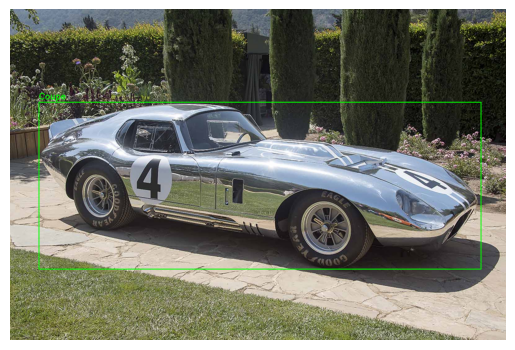

In [26]:
test_img = "/kaggle/input/car-body-style-dataset/CarBodyStyles/Coupe/0ab3f024-66b3-11eb-ba1e-8c164571e025.jpg"

output = detect_and_classify(test_img)

plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")



image 1/1 /kaggle/input/car-body-style-dataset/CarBodyStyles/Convertible/d812eb34-66b6-11eb-9f7d-8c164571e025.jpg: 640x480 1 car, 45.8ms
Speed: 2.5ms preprocess, 45.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


(np.float64(-0.5), np.float64(899.5), np.float64(1199.5), np.float64(-0.5))

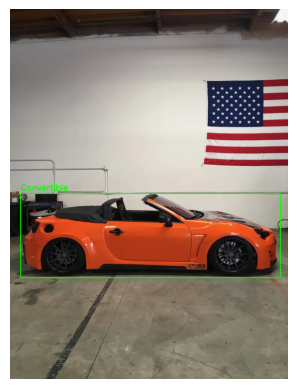

In [27]:
test_img = "/kaggle/input/car-body-style-dataset/CarBodyStyles/Convertible/d812eb34-66b6-11eb-9f7d-8c164571e025.jpg"

output = detect_and_classify(test_img)

plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
